# Prediction on Hurricane Landfall Using Guassian Process Regression

## Introduction

Hurricane is one of the most destructive natural disasters in the US. A level-4 or level-5 hurricane that lands on a coastal area can destroy thousands of buildings and cause multibillion-dollar damage to the country. Therefore, developing a statistical tool that can predict the number of landfall, an event when a storm hits the land after being over water, is useful for a both the governmental agencies and the public to prepare themselves and handle potential damages caused by a storm. For this project, my focus will be on predicting the number of landfalls in the US Eastern coastal area using Guassian Process Regression technique, with the help of some unsupervised techniques on the preprocessing part, to model the annual number of landfalls.

Storms, in general, can be formed both on land and on sea surface. For most of the storms hitting the Eastern coast of the US, they are formed on the sea surface in the Atlantic Ocean because of extreme sea surface temperature anamolies. According to the National Weather Service, the hurricane season begins on May 15 and ends on November 30 on every year. Therefore, my assumption is that, every year, the average value of the sea surface temperature anamoly (SSTA) in each area in the Atlantic Ocean across during the beginning of the annual hurricane season should give some valuable information about the number of hurricanes hitting the Eastern coast during the season. 

## Data

With the assumption on the relationships between the number of landfalls and sea surface temperature anomalies, the data used for this project consist of the following. First, the annual numbers of hurricane landfalls in the whole basin of the US Eastern coastal area from 1851 to 2016. Second, the sea surface temperature anomaly data in each gridded 2.5-latitude-by-2.5-longitude area of the Pacific Ocean measured annually during May from 1851 to 2016. Both of the datasets are given by Lamont-Doherty Earth Observatory of Columbia University. For this experiment, the gridded data used cover the whole North Atlantic Ocean. Hence, there exist 166 observations and 183 dimensions in total.

## Modeling

This project uses Guassian Process Regression (GPR) technique [Rasmussen and Williams, 2006] for the prediction. GPR is a Bayesian nonparametric technique used for both classification and regression. Our case of prediction falls into the regression category using noisy observations, and we can describe the general form of GPR for our case as the following.

Let $y$ be observations included with noise, $f\left(x\right)$ a function value over the domain of $x$, and $\epsilon$ be independent identically distributed Guassian noise. Then, the noisy version of observation has the assumption that $y = f\left(x\right) + \epsilon$. Also, the prior on the noisy observations for covariance becomes $cov\left(y_{p},y_{q}\right) = k\left(x_{p},x_{q}\right) = k\left(x_{p},x_{q}\right) + \sigma^{2}_{n}\delta_{pq}$ or $cov\left(y\right) = K\left(X,X\right) + \sigma^{2}_{n}I$ where $\delta_{pq}$ is a Kronecker delta with $\delta_{pq} = 1$ when $p = q$ and 0 otherwise, $K$ being a kernel matrix and $X$ being a matrix of training dataset. Hence, we can write the joint distribution of the observations and the function value at the test location, $X_{*}$ under the prior as

\begin{equation*}
\begin{bmatrix}y \\ f_{*} \end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix}m \\ m_{*} \end{bmatrix}, \begin{pmatrix}K\left(X,X\right) + \sigma^{2}_{n}I & K\left(X,X_{*}\right) \\ K\left(X_{*}, X\right) & K\left(X_{*}, X_{*}\right)\end{pmatrix}\right),
\end{equation*}

with $m$ being the mean vector of all observations and $m_{*}$ being the mean of test data.

The key to GPR's predictive performance lies upon the correct kernel design for the covariance matrix. For this experiment, the chosen final kernel is the sum of the three following kernels, which will still be a kernel as proved in [Rasmussen and Williams, 2006].

### 1. Squared Exponential Kernel

\begin{equation*}
k_{SE}\left(x,x'\right) = \theta_{1}^{2}exp\left(-\frac{||x-x'||^{2}}{2\theta_{2}^{2}}\right)
\end{equation*}

- The kernel is used for estimating the long-run trend due to its smoothness.

### 2. Matern Kernel with Nu = 5/2

\begin{equation*}
k_{matern, \nu = 5/2}\left(x,x'\right) = \left(1 + \frac{\sqrt{5}\cdot||x-x'||}{\theta_{3}} + \frac{5||x-x'||^{2}}{3\theta_{3}^{2}}\right)exp\left(-\frac{\sqrt{5}||x-x'||}{\theta_{3}}\right)
\end{equation*}

- This kernel is less smooth than the SE kernel, so it should be able to capture either long-run or medium-run variation in the data.

### 3. Rational Quadratic Kernel

\begin{equation*}
k_{RQ}\left(x,x'\right) = \theta_{6}^{2}\left(1 + \frac{||x - x'||^{2}}{2\theta_{7}^{2}\theta_{8}}\right)^{-\theta_{8}}
\end{equation*}

- This kernel is finally added to model the short-run or medium-run irregularity in the data.

Therefore, the final value of the kernels used would be as the following.

\begin{equation*}
k_{final}\left(x,x'\right) = k_{SE}\left(x,x'\right) + k_{matern, \nu = 5/2}\left(x,x'\right) + k_{RQ}\left(x,x'\right)
\end{equation*}

### Dimensional Reduction on Feature Space

With the number of dimensions being very large compared with the number of observations, a possible pitfall about using GPR, whose predictive performance relies on the structure of kernel space, for the data becomes the curse of dimensionality. In order to handle this potential issue, this project applies two dimensional-reduction techniques on the feature space as the following.

#### 1. Principal Component Analysis (PCA)
- For this case, PCA is applied to the feature space, with the number of principal components vary from k = 3 to k = 10. Despite the different number of principal components used in the project, the assumption behind is the data space can be defined well enough on a hyperplane.

#### 2. Large Margin Nearest Neighbor (LMNN)
- LMNN is a supervised dimensional reduction technique with the assumption of linear space also used for data projection. For more information about LMNN, please see [Weinberger, 2005]. With space of the target value lying between $0$ and $7$ inclusively, I classify the original data into three groups as the following.

    1. Group 0 for $y=0$
    2. Group 1 for $y \in \left\{1,2,3\right\}$
    3. Group 2 for $y \geq 4$

    Then, I extract from the principal components gained from the algorithm from k = 3 to k = 10. 

## Inference

This project uses Black-Box Variational Inference as the main tool on estimating the mean values of the target functions. The structure of the calculation will be as the following.

Step 0: Apply the the dimensional reduction technique on the data and estimate the hyperparameters used in the kernel functions

Step 1: Evaluate kernel matrices of the input data with the hyperparameters calculated from step 1

Step 2: Estimate the expectation of the target functions

Step 3: Calculate the mean square error from the values calculated from step 2

## Criticism

As this project will test the model's performance by using LOOCV in order to be able to be directly compared with the results from other papers, we can derive the form of the prediction for each validation data point as the following. Let $k_{*}$ denote the vector of covariances between the test point and the $n$ training points. Then, the expectation of test function value is as the following.

\begin{equation*}
\bar{f}_{*} = m_{*} + k_{*}^{T}\left(K + \sigma_{n}^{2}I\right)^{-1}(y - m)
\end{equation*}

The performances derived from all of the experiments are as the following.

### LOOCV Error From Using LMNN Compared with The Full Dataset

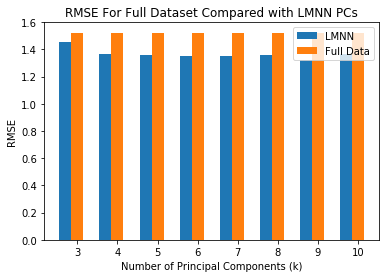

<Figure size 1440x720 with 0 Axes>

In [21]:
import numpy as np
import matplotlib.pyplot as plt

lmnn_error = np.array([1.453,1.367,1.357,1.354,1.351,1.356,1.325,1.366])
all_error = np.array([1.522,1.522,1.522,1.522,1.522,1.522,1.522,1.522])
width = 0.3
range_all = np.arange(3,11)
p1 = plt.bar(range_all, lmnn_error, width, label = 'LMNN')
p2 = plt.bar(range_all+width, all_error, width, label = 'Full Data')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('RMSE')
plt.title('RMSE For Full Dataset Compared with LMNN PCs')
plt.xticks(range_all + width, ('3', '4', '5', '6', '7', '8', '9', '10'))
plt.legend()
plt.figure(figsize=(20,10))

plt.tight_layout()
plt.show()

The validation RMSE obtained from LOOCV for the two cases as the following.

- Using Full data: 1.522
- Using LMNN: 1.325 (Smallest error with k = 9)

Hence, the reduction in RMSE with the help of LMNN is around 15%.

### LOOCV Error From Using PCA Compared with The Full Dataset

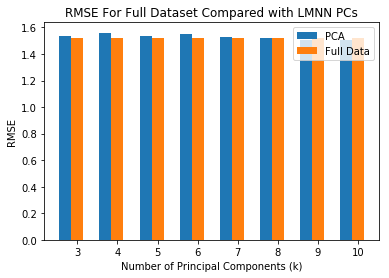

<Figure size 1440x720 with 0 Axes>

In [24]:
pca_error = np.array([1.534,1.560,1.534,1.551,1.531,1.519,1.508,1.508])
p1 = plt.bar(range_all, pca_error, width, label = 'PCA')
p2 = plt.bar(range_all+width, all_error, width, label = 'Full Data')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('RMSE')
plt.title('RMSE For Full Dataset Compared with LMNN PCs')
plt.xticks(range_all + width, ('3', '4', '5', '6', '7', '8', '9', '10'))
plt.legend()
plt.figure(figsize=(20,10))

plt.tight_layout()
plt.show()

The performance obtained from the algorithm is still not satisfiable, compared with the RMSE obtained by the most accurate model provided by [Yan et al, 2015], which gives RMSE = 0.806. The major problem seen in this model is the overfitting part with most of training error becoming very close to 0.

The following processes may be helpful on improving the result.

1) Focus more on only some dimensions in the input data, which are highly informative. 

2) Use semi-supervised techniques for kernel function instead

3) (For algorithm part) Use better data structure / faster algorithm to calculate the expectatiions of the target values and hyperparameters 

4) (Harder to implement) Design a more specific objective function that penalizes more on the case when there is a false negative prediction because predicting that there will not be any hurricane when actually the hurricane happens is very deleterious.

## Reference

- Rasmussen, C. E., & Williams, C. K. (2006). Gaussian Processes for Machine Learning. MIT Press, 2006.
- Weinberger, Kilian Q. and Blitzer, John and Saul, Lawrence K. (2005), Distance Metric Learning for Large Margin Nearest Neighbor Classification, NIPS'05 Proceedings of the 18th International Conference on Neural Information Processing Systems p. 1473-1480, MIT Press
- Yan, T., Pietrafesa, L.J., Dickey, D.A., Gayes, P.T., Bao, S. (2015), Seasonal Prediction of Landfalling Hurricanes along Eastern Seaboard of the United States, International Journal of Climatology, 35, 2647 - 2653